In [1]:
! pwd

/cluster/home/taekim/stressed_mice/jupyter_notebooks


In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from datetime import datetime

def run_random_forest_feature_selection(input_file_path, output_dir=None, top_n=50):
    """
    Perform Random Forest feature selection analysis on genomic data.
    
    Parameters:
    -----------
    input_file_path : str
        Path to the input CSV file with genomic data
    output_dir : str, optional
        Directory where output files will be saved. If None, uses the current directory.
    top_n : int, optional
        Number of top features to highlight in detailed analysis, default is 50
        
    Returns:
    --------
    results_df : pandas.DataFrame
        DataFrame containing results of feature selection experiments
    importance_df : pandas.DataFrame
        DataFrame containing all features ranked by importance
    """
    # Set default output directory if none provided
    if output_dir is None:
        output_dir = ''
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Define a mapping from NCBI RefSeq accessions to UCSC chromosome names
    # Based on standard mouse genome mapping (assuming this is mouse data from the RefSeq IDs)
    chrom_dict = {
    'NC_000067.7': 'chr1',
    'NC_000067.8': 'chr1',
    'NC_000068.7': 'chr2',
    'NC_000068.8': 'chr2',
    'NC_000069.7': 'chr3',
    'NC_000069.8': 'chr3',
    'NC_000070.7': 'chr4',
    'NC_000070.8': 'chr4',
    'NC_000071.7': 'chr5',
    'NC_000071.8': 'chr5',
    'NC_000072.7': 'chr6',
    'NC_000072.8': 'chr6',
    'NC_000073.7': 'chr7',
    'NC_000073.8': 'chr7',
    'NC_000074.7': 'chr8',
    'NC_000074.8': 'chr8',
    'NC_000075.7': 'chr9',
    'NC_000075.8': 'chr9',
    'NC_000076.7': 'chr10',
    'NC_000076.8': 'chr10',
    'NC_000077.7': 'chr11',
    'NC_000077.8': 'chr11',
    'NC_000078.7': 'chr12',
    'NC_000078.8': 'chr12',
    'NC_000079.7': 'chr13',
    'NC_000079.8': 'chr13',
    'NC_000080.7': 'chr14',
    'NC_000080.8': 'chr14',
    'NC_000081.7': 'chr15',
    'NC_000081.8': 'chr15',
    'NC_000082.7': 'chr16',
    'NC_000082.8': 'chr16',
    'NC_000083.7': 'chr17',
    'NC_000083.8': 'chr17',
    'NC_000084.7': 'chr18',
    'NC_000084.8': 'chr18',
    'NC_000085.7': 'chr19',
    'NC_000085.8': 'chr19',
    'NC_000086.8': 'chrX',
    'NC_000086.9': 'chrX',
    'NC_000087.8': 'chrY',
    'NC_000087.9': 'chrY',
    'NC_005089.1': 'chrM'
    # Add any other mappings as needed
    }
    # Function to parse bin_id and create new UCSC style ID
    def create_ucsc_style_id(bin_id):
        match = re.match(r'^(\d+\.\d+)_([+-])(.+)$', bin_id)
        if match:
            index = float(match.group(1))
            strand = match.group(2)
            ref_seq = match.group(3)
            
            if ref_seq in chrom_dict:
                # Convert index to integer
                return f"{chrom_dict[ref_seq]}{strand}{int(index)}"
        return bin_id  # Return original if conversion fails

    # Read the data
    print(f"Reading data from {input_file_path}...")
    df = pd.read_csv(input_file_path)

    # Create feature IDs first (as in the original code)
    df['FeatureID'] = df['Bin'].astype(str) + '_' + df['Strand'] + df['Chromosome'].astype(str)

    # Now convert these IDs to UCSC style
    df['UCSCFeatureID'] = df['FeatureID'].apply(create_ucsc_style_id)

    # Print some examples to verify the conversion
    print("\nExample UCSC Feature IDs:")
    for i, (orig, ucsc) in enumerate(zip(df['FeatureID'], df['UCSCFeatureID'])):
        if i < 5:  # Show first 5 examples
            print(f"  Original: {orig} → UCSC: {ucsc}")

    # Create pivot table with UCSC-style IDs
    pivot_df = df.pivot_table(index='Sample', 
                             columns='UCSCFeatureID', 
                             values='Median_Normalized_Damage',
                             aggfunc='mean')

    print(f"Data shape: {pivot_df.shape} (samples × features)")

    # Extract sample groups
    def extract_group(sample_name):
        match = re.search(r'(CRS|Ctrl)_(evening|morning)', sample_name)
        if match:
            return match.group(0)
        else:
            return "Unknown"

    # Create target variable and analyze class distribution
    sample_groups = [extract_group(sample) for sample in pivot_df.index]
    y = np.array(sample_groups)
    unique_groups, group_counts = np.unique(y, return_counts=True)
    print("\nSample group distribution:")
    for group, count in zip(unique_groups, group_counts):
        print(f"  {group}: {count} samples")

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Prepare feature data
    X = pivot_df.values
    X = np.nan_to_num(X, nan=0.0)  # Replace NaN with zero

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Calculate initial feature importance
    print("\nCalculating feature importance...")
    rf = RandomForestClassifier(n_estimators=500, random_state=42, class_weight='balanced', n_jobs=-1)
    rf.fit(X_scaled, y_encoded)

    # Create importance dataframe with feature metadata
    importance_df = pd.DataFrame({
        'Feature': pivot_df.columns,
        'Importance': rf.feature_importances_
    })
    importance_df = importance_df.sort_values('Importance', ascending=False)

    # Extract genomic information from UCSC-style IDs
    def extract_ucsc_info(ucsc_id):
        # Pattern to match UCSC style IDs like chr1+12345
        match = re.match(r'^(chr[^+-]+)([+-])(\d+)$', ucsc_id)
        if match:
            chrom = match.group(1)
            strand = match.group(2)
            position = int(match.group(3))
            return chrom, strand, position
        else:
            # For non-matching IDs, try to extract using original pattern
            match = re.match(r'^(\d+\.\d+)_([+-])(.+)$', ucsc_id)
            if match:
                bin_val = match.group(1)
                strand = match.group(2)
                chrom = match.group(3)
                return chrom, strand, bin_val
            return "Unknown", "?", "Unknown"

    # Add genomic information to importance dataframe
    importance_df['Chromosome'] = importance_df['Feature'].apply(lambda x: extract_ucsc_info(x)[0])
    importance_df['Strand'] = importance_df['Feature'].apply(lambda x: extract_ucsc_info(x)[1])
    importance_df['Position'] = importance_df['Feature'].apply(lambda x: extract_ucsc_info(x)[2])

    # Save all feature importance
    all_features_file = os.path.join(output_dir, 'all_features_importance.csv')
    importance_df.to_csv(all_features_file, index=False)
    print(f"Saved all features to {all_features_file}")

    # Save top N features with detailed information
    top_n_file = os.path.join(output_dir, f'top_{top_n}_features.csv')
    top_n_features = importance_df.head(top_n).copy()

    # Add percentile and cumulative importance to top N
    top_n_features['Percentile'] = top_n_features['Importance'].rank(pct=True) * 100
    top_n_features['Cumulative_Importance'] = top_n_features['Importance'].cumsum() / importance_df['Importance'].sum() * 100

    # Save top N features with enhanced information
    top_n_features.to_csv(top_n_file, index=False)
    print(f"\nSaved top {top_n} features to {top_n_file}")
    print(f"Top 10 Features (UCSC-style):")
    for i, (feature, importance) in enumerate(zip(top_n_features['Feature'].head(10), 
                                                 top_n_features['Importance'].head(10))):
        print(f"  {i+1}. {feature}: {importance:.6f}")

    # Create a visualization of the top N features
    plt.figure(figsize=(12, 10))
    plt.barh(np.arange(min(top_n, len(top_n_features))), 
             top_n_features['Importance'], align='center')
    plt.yticks(np.arange(min(top_n, len(top_n_features))), 
              [f"{i+1}. {f}" for i, f in enumerate(top_n_features['Feature'])])
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Features by Importance (UCSC Style)')
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.tight_layout()
    top_n_plot_file = os.path.join(output_dir, f'top_{top_n}_features_plot.png')
    plt.savefig(top_n_plot_file, dpi=300)
    print(f"Saved feature importance plot to {top_n_plot_file}")

    # Define feature counts to test
    total_features = len(importance_df)
    feature_counts = [1, 5, 10, 25, 50, 100, 250, 500, 1000, 10000, 100000, 1000000, total_features]
    feature_counts = [count for count in feature_counts if count <= total_features]

    # Run feature selection experiment
    print(f"\nTesting accuracy with different feature counts: {feature_counts}")
    results = []

    # Use stratified K-fold for more reliable estimates
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for n_features in feature_counts:
        # Get top n features
        top_features = importance_df.head(n_features)['Feature'].values
        feature_indices = [list(pivot_df.columns).index(feature) for feature in top_features]
        
        # Test with subset of features
        X_subset = X_scaled[:, feature_indices]
        
        # Cross-validation
        rf_subset = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
        cv_scores = cross_val_score(rf_subset, X_subset, y_encoded, cv=skf, scoring='accuracy')
        
        # Record results
        results.append({
            'n_features': n_features,
            'accuracy': cv_scores.mean(),
            'std_dev': cv_scores.std(),
            'min_accuracy': cv_scores.min(),
            'max_accuracy': cv_scores.max()
        })
        
        print(f"  {n_features} features: {cv_scores.mean():.4f} accuracy (± {cv_scores.std():.4f})")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    results_file = os.path.join(output_dir, 'feature_selection_results.csv')
    results_df.to_csv(results_file, index=False)
    print(f"Saved feature selection results to {results_file}")

    # Find best result
    best_idx = results_df['accuracy'].idxmax()
    best_features = results_df.loc[best_idx, 'n_features']
    best_accuracy = results_df.loc[best_idx, 'accuracy']

    # Plot accuracy vs. feature count
    plt.figure(figsize=(12, 7))
    plt.plot(results_df['n_features'], results_df['accuracy'], 'o-', color='blue', linewidth=2)

    # Add error bands
    plt.fill_between(
        results_df['n_features'], 
        results_df['accuracy'] - results_df['std_dev'],
        results_df['accuracy'] + results_df['std_dev'],
        alpha=0.2, color='blue'
    )

    # Highlight best result
    plt.plot(best_features, best_accuracy, 'ro', markersize=10)

    # Highlight the result with top_n features
    result_top_n = results_df[results_df['n_features'] == top_n]
    if not result_top_n.empty:
        plt.plot(top_n, result_top_n['accuracy'].values[0], 'go', markersize=10)
        plt.annotate(f"{top_n} features: {result_top_n['accuracy'].values[0]:.3f}", 
                    (top_n, result_top_n['accuracy'].values[0]),
                    xytext=(5, 10), textcoords='offset points', color='green')

    # Add annotations for each point
    for i, row in results_df.iterrows():
        if row['n_features'] != top_n:  # Skip top_n which is already annotated in green
            plt.annotate(
                f"{row['n_features']}: {row['accuracy']:.3f}",
                (row['n_features'], row['accuracy']),
                xytext=(5, 5),
                textcoords='offset points'
            )

    # Format plot
    plt.xscale('log')
    plt.xlabel('Number of Features (log scale)')
    plt.ylabel('Cross-Validation Accuracy')
    plt.title('Feature Selection: Accuracy vs Number of Features')
    plt.grid(True, alpha=0.3)

    # Add summary text
    textstr = (f'Best accuracy: {best_accuracy:.4f} with {best_features} features\n'
              f'Top {top_n} accuracy: {result_top_n["accuracy"].values[0]:.4f}\n'
              f'Total features: {total_features}')
    plt.annotate(textstr, (0.02, 0.98), xycoords='axes fraction', va='top', 
                bbox=dict(boxstyle='round', fc='white', alpha=0.7))
    
    accuracy_plot_file = os.path.join(output_dir, 'accuracy_vs_features_plot.png')
    plt.savefig(accuracy_plot_file, dpi=300)
    print(f"Saved accuracy plot to {accuracy_plot_file}")

    print("\nAnalysis complete! Results saved to:", output_dir)
    print(f"Best model: {best_features} features with {best_accuracy:.4f} accuracy")
    
    return results_df, importance_df



Reading data from ../data_normalized/cleaned_Normalized_100000.csv...

Example UCSC Feature IDs:
  Original: 3000000.0_+NC_000067.7 → UCSC: chr1+3000000
  Original: 3000000.0_-NC_000067.7 → UCSC: chr1-3000000
  Original: 3100000.0_+NC_000067.7 → UCSC: chr1+3100000
  Original: 3100000.0_-NC_000067.7 → UCSC: chr1-3100000
  Original: 3200000.0_+NC_000067.7 → UCSC: chr1+3200000
Data shape: (20, 53168) (samples × features)

Sample group distribution:
  CRS_evening: 5 samples
  CRS_morning: 5 samples
  Ctrl_evening: 5 samples
  Ctrl_morning: 5 samples

Calculating feature importance...
Saved all features to ../data_rf/bin100000/all_features_importance.csv

Saved top 50 features to ../data_rf/bin100000/top_50_features.csv
Top 10 Features (UCSC-style):
  1. chr7-17400000: 0.002816
  2. chr8-10200000: 0.002796
  3. chrX+43500000: 0.002639
  4. chr1+149700000: 0.002182
  5. chr6+84900000: 0.002125
  6. chr9+71200000: 0.001991
  7. chrY-72100000: 0.001959
  8. chr18+14200000: 0.001853
  9. chr5-7

(    n_features  accuracy   std_dev  min_accuracy  max_accuracy
 0            1      0.55  0.187083          0.25          0.75
 1            5      0.95  0.100000          0.75          1.00
 2           10      0.90  0.122474          0.75          1.00
 3           25      0.95  0.100000          0.75          1.00
 4           50      0.95  0.100000          0.75          1.00
 5          100      0.95  0.100000          0.75          1.00
 6          250      0.95  0.100000          0.75          1.00
 7          500      0.95  0.100000          0.75          1.00
 8         1000      0.95  0.100000          0.75          1.00
 9        10000      0.55  0.291548          0.25          1.00
 10       53168      0.40  0.200000          0.25          0.75,
               Feature  Importance Chromosome Strand   Position
 42187   chr7-17400000    0.002816       chr7      -   17400000
 44369   chr8-10200000    0.002796       chr8      -   10200000
 49081   chrX+43500000    0.002639     

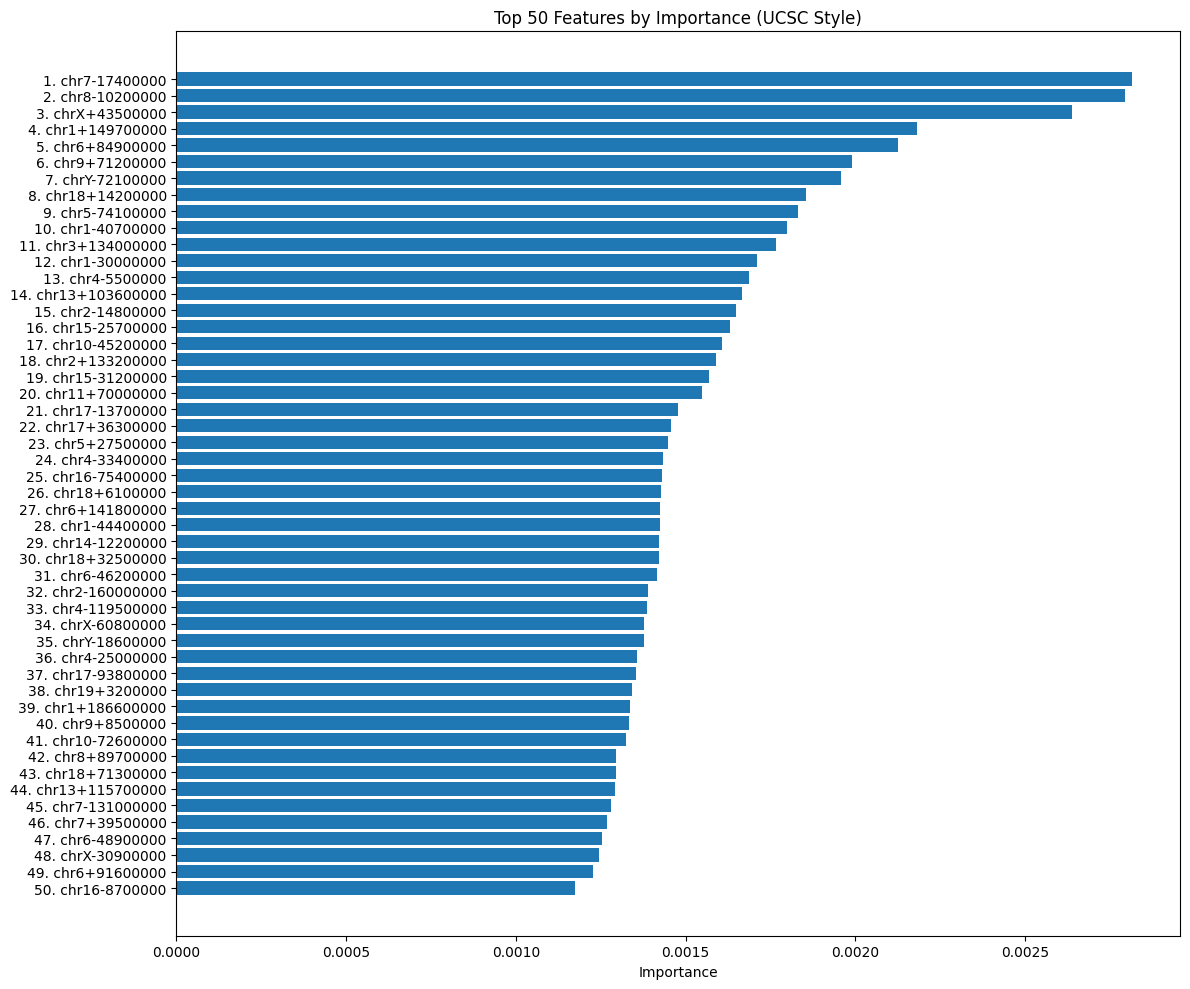

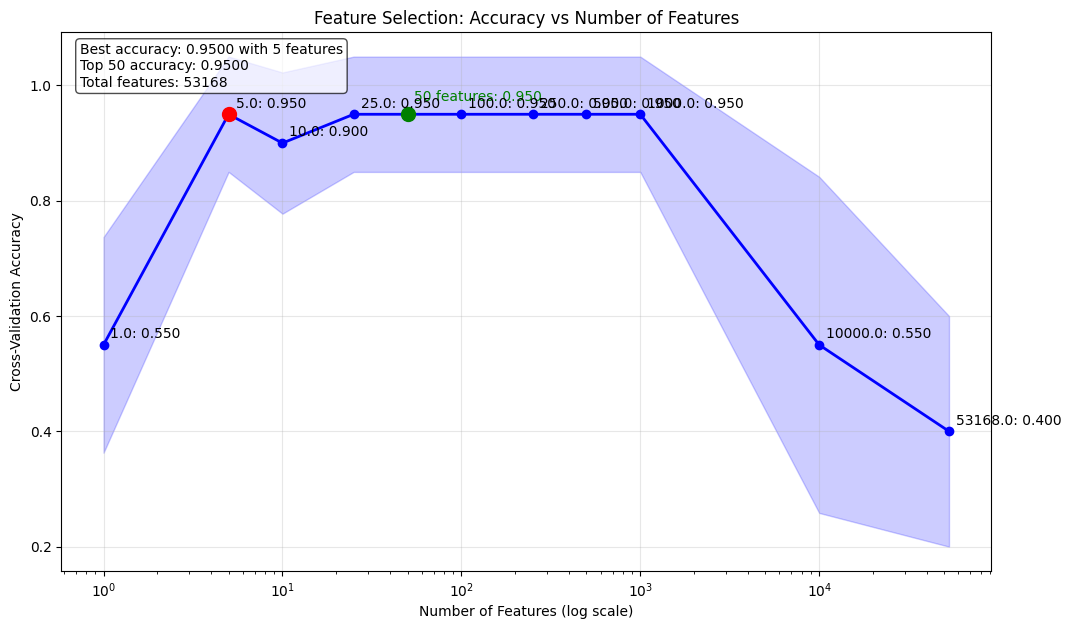

In [6]:
run_random_forest_feature_selection(
        input_file_path='../data_normalized/cleaned_Normalized_100000.csv',
        output_dir='../data_rf/bin100000',
        top_n=50 )

Reading data from ../data_normalized/cleaned_Normalized_10000.csv...

Example UCSC Feature IDs:
  Original: 3040000.0_-NC_000067.7 → UCSC: chr1-3040000
  Original: 3050000.0_+NC_000067.7 → UCSC: chr1+3050000
  Original: 3050000.0_-NC_000067.7 → UCSC: chr1-3050000
  Original: 3060000.0_+NC_000067.7 → UCSC: chr1+3060000
  Original: 3060000.0_-NC_000067.7 → UCSC: chr1-3060000
Data shape: (20, 530255) (samples × features)

Sample group distribution:
  CRS_evening: 5 samples
  CRS_morning: 5 samples
  Ctrl_evening: 5 samples
  Ctrl_morning: 5 samples

Calculating feature importance...
Saved all features to ../data_rf/bin10000/all_features_importance.csv

Saved top 50 features to ../data_rf/bin10000/top_50_features.csv
Top 10 Features (UCSC-style):
  1. chr16+41560000: 0.001660
  2. chr4-15710000: 0.001524
  3. chr7+53350000: 0.001415
  4. chr12-58700000: 0.001290
  5. chr11-73070000: 0.001253
  6. chrX-62270000: 0.001253
  7. chr16+20590000: 0.001253
  8. chr1+52760000: 0.001244
  9. chr10+

(    n_features  accuracy   std_dev  min_accuracy  max_accuracy
 0            1      0.20  0.187083          0.00          0.50
 1            5      0.70  0.100000          0.50          0.75
 2           10      0.70  0.187083          0.50          1.00
 3           25      0.95  0.100000          0.75          1.00
 4           50      0.90  0.122474          0.75          1.00
 5          100      0.95  0.100000          0.75          1.00
 6          250      0.95  0.100000          0.75          1.00
 7          500      0.95  0.100000          0.75          1.00
 8         1000      0.95  0.100000          0.75          1.00
 9        10000      0.70  0.187083          0.50          1.00
 10      100000      0.50  0.223607          0.25          0.75
 11      530255      0.55  0.291548          0.00          0.75,
                Feature  Importance Chromosome Strand  Position
 182142  chr16+41560000    0.001660      chr16      +  41560000
 333861   chr4-15710000    0.001524    

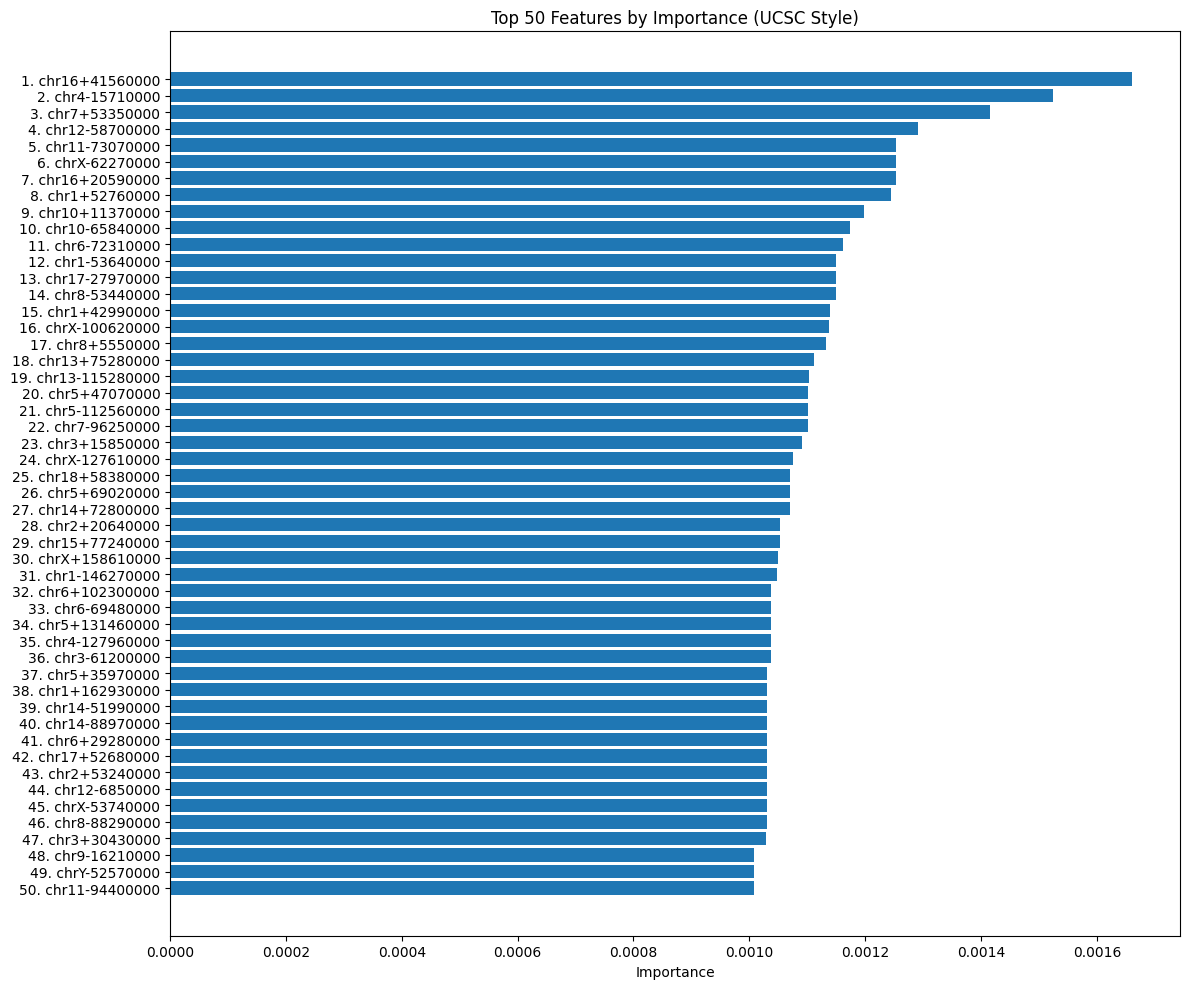

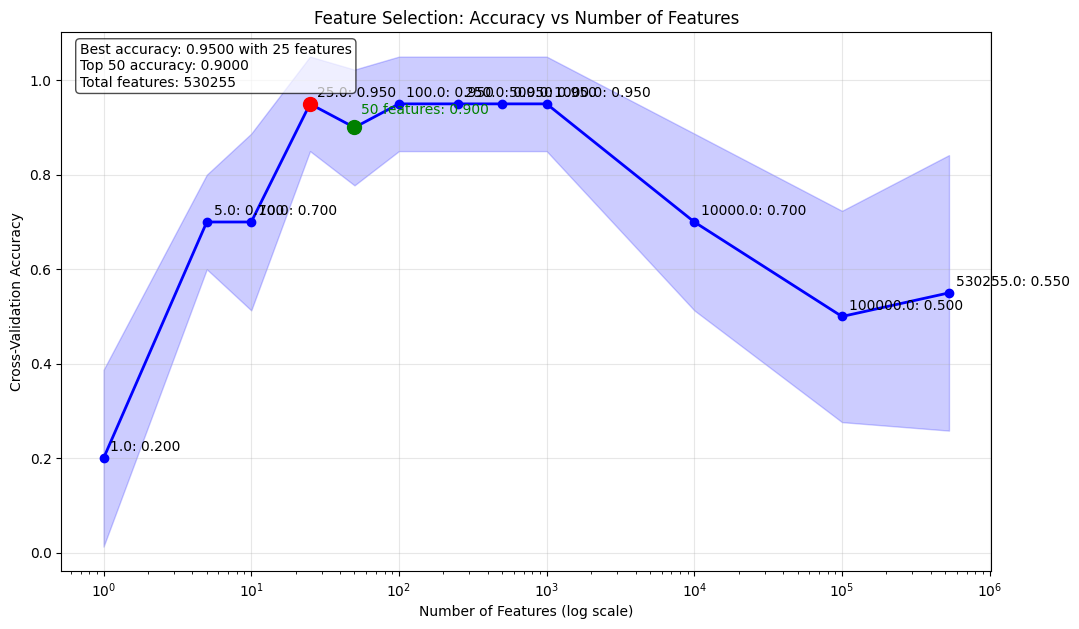

In [7]:
run_random_forest_feature_selection(
        input_file_path='../data_normalized/cleaned_Normalized_10000.csv',
        output_dir='../data_rf/bin10000',
        top_n=50 )

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from datetime import datetime
from joblib import Parallel, delayed
import multiprocessing

def run_random_forest_feature_selection_p(input_file_path, output_dir=None, top_n=50, n_jobs=None):
    """
    Perform Random Forest feature selection analysis on genomic data with parallelization.
    
    Parameters:
    -----------
    input_file_path : str
        Path to the input CSV file with genomic data
    output_dir : str, optional
        Directory where output files will be saved. If None, uses the current directory.
    top_n : int, optional
        Number of top features to highlight in detailed analysis, default is 50
    n_jobs : int, optional
        Number of jobs for parallelization. If None, uses all available cores.
        
    Returns:
    --------
    results_df : pandas.DataFrame
        DataFrame containing results of feature selection experiments
    importance_df : pandas.DataFrame
        DataFrame containing all features ranked by importance
    """
    # Set default parameters
    if output_dir is None:
        output_dir = ''
    
    if n_jobs is None:
        n_jobs = multiprocessing.cpu_count()
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Define a mapping from NCBI RefSeq accessions to UCSC chromosome names
    # Based on standard mouse genome mapping (assuming this is mouse data from the RefSeq IDs)
    chrom_dict = {
        'NC_000067.7': 'chr1',
        'NC_000067.8': 'chr1',
        'NC_000068.7': 'chr2',
        'NC_000068.8': 'chr2',
        'NC_000069.7': 'chr3',
        'NC_000069.8': 'chr3',
        'NC_000070.7': 'chr4',
        'NC_000070.8': 'chr4',
        'NC_000071.7': 'chr5',
        'NC_000071.8': 'chr5',
        'NC_000072.7': 'chr6',
        'NC_000072.8': 'chr6',
        'NC_000073.7': 'chr7',
        'NC_000073.8': 'chr7',
        'NC_000074.7': 'chr8',
        'NC_000074.8': 'chr8',
        'NC_000075.7': 'chr9',
        'NC_000075.8': 'chr9',
        'NC_000076.7': 'chr10',
        'NC_000076.8': 'chr10',
        'NC_000077.7': 'chr11',
        'NC_000077.8': 'chr11',
        'NC_000078.7': 'chr12',
        'NC_000078.8': 'chr12',
        'NC_000079.7': 'chr13',
        'NC_000079.8': 'chr13',
        'NC_000080.7': 'chr14',
        'NC_000080.8': 'chr14',
        'NC_000081.7': 'chr15',
        'NC_000081.8': 'chr15',
        'NC_000082.7': 'chr16',
        'NC_000082.8': 'chr16',
        'NC_000083.7': 'chr17',
        'NC_000083.8': 'chr17',
        'NC_000084.7': 'chr18',
        'NC_000084.8': 'chr18',
        'NC_000085.7': 'chr19',
        'NC_000085.8': 'chr19',
        'NC_000086.8': 'chrX',
        'NC_000086.9': 'chrX',
        'NC_000087.8': 'chrY',
        'NC_000087.9': 'chrY',
        'NC_005089.1': 'chrM'
    }
    
    # Function to parse bin_id and create new UCSC style ID
    def create_ucsc_style_id(bin_id):
        match = re.match(r'^(\d+\.\d+)_([+-])(.+)$', bin_id)
        if match:
            index = float(match.group(1))
            strand = match.group(2)
            ref_seq = match.group(3)
            
            if ref_seq in chrom_dict:
                # Convert index to integer
                return f"{chrom_dict[ref_seq]}{strand}{int(index)}"
        return bin_id  # Return original if conversion fails

    # Read the data
    print(f"Reading data from {input_file_path}...")
    df = pd.read_csv(input_file_path)

    # Create feature IDs
    df['FeatureID'] = df['Bin'].astype(str) + '_' + df['Strand'] + df['Chromosome'].astype(str)

    # Convert IDs to UCSC style in parallel
    print("Converting feature IDs to UCSC style in parallel...")
    df['UCSCFeatureID'] = Parallel(n_jobs=n_jobs)(
        delayed(create_ucsc_style_id)(fid) for fid in df['FeatureID']
    )

    # Print some examples to verify the conversion
    print("\nExample UCSC Feature IDs:")
    for i, (orig, ucsc) in enumerate(zip(df['FeatureID'], df['UCSCFeatureID'])):
        if i < 5:  # Show first 5 examples
            print(f"  Original: {orig} → UCSC: {ucsc}")

    # Create pivot table with UCSC-style IDs
    pivot_df = df.pivot_table(index='Sample', 
                             columns='UCSCFeatureID', 
                             values='Median_Normalized_Damage',
                             aggfunc='mean')

    print(f"Data shape: {pivot_df.shape} (samples × features)")

    # Extract sample groups
    def extract_group(sample_name):
        match = re.search(r'(CRS|Ctrl)_(evening|morning)', sample_name)
        if match:
            return match.group(0)
        else:
            return "Unknown"

    # Process sample groups in parallel
    print("Extracting sample groups...")
    sample_groups = Parallel(n_jobs=n_jobs)(
        delayed(extract_group)(sample) for sample in pivot_df.index
    )
    
    y = np.array(sample_groups)
    unique_groups, group_counts = np.unique(y, return_counts=True)
    print("\nSample group distribution:")
    for group, count in zip(unique_groups, group_counts):
        print(f"  {group}: {count} samples")

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Prepare feature data
    X = pivot_df.values
    X = np.nan_to_num(X, nan=0.0)  # Replace NaN with zero

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Calculate initial feature importance
    print("\nCalculating feature importance with parallel Random Forest...")
    # n_jobs=-1 in RandomForestClassifier already uses parallelization
    rf = RandomForestClassifier(n_estimators=500, random_state=42, class_weight='balanced', n_jobs=-1)
    rf.fit(X_scaled, y_encoded)

    # Create importance dataframe with feature metadata
    importance_df = pd.DataFrame({
        'Feature': pivot_df.columns,
        'Importance': rf.feature_importances_
    })
    importance_df = importance_df.sort_values('Importance', ascending=False)

    # Extract genomic information from UCSC-style IDs (helper function)
    def extract_ucsc_info(ucsc_id):
        # Pattern to match UCSC style IDs like chr1+12345
        match = re.match(r'^(chr[^+-]+)([+-])(\d+)$', ucsc_id)
        if match:
            chrom = match.group(1)
            strand = match.group(2)
            position = int(match.group(3))
            return chrom, strand, position
        else:
            # For non-matching IDs, try to extract using original pattern
            match = re.match(r'^(\d+\.\d+)_([+-])(.+)$', ucsc_id)
            if match:
                bin_val = match.group(1)
                strand = match.group(2)
                chrom = match.group(3)
                return chrom, strand, bin_val
            return "Unknown", "?", "Unknown"
    
    # Extract genomic information in parallel
    print("Extracting genomic information in parallel...")
    genomic_info = Parallel(n_jobs=n_jobs)(
        delayed(extract_ucsc_info)(feature) for feature in importance_df['Feature']
    )
    
    # Unpack the results
    importance_df['Chromosome'] = [info[0] for info in genomic_info]
    importance_df['Strand'] = [info[1] for info in genomic_info]
    importance_df['Position'] = [info[2] for info in genomic_info]

    # Save all feature importance
    all_features_file = os.path.join(output_dir, 'all_features_importance.csv')
    importance_df.to_csv(all_features_file, index=False)
    print(f"Saved all features to {all_features_file}")

    # Save top N features with detailed information
    top_n_file = os.path.join(output_dir, f'top_{top_n}_features.csv')
    top_n_features = importance_df.head(top_n).copy()

    # Add percentile and cumulative importance to top N
    top_n_features['Percentile'] = top_n_features['Importance'].rank(pct=True) * 100
    top_n_features['Cumulative_Importance'] = top_n_features['Importance'].cumsum() / importance_df['Importance'].sum() * 100

    # Save top N features with enhanced information
    top_n_features.to_csv(top_n_file, index=False)
    print(f"\nSaved top {top_n} features to {top_n_file}")
    print(f"Top 10 Features (UCSC-style):")
    for i, (feature, importance) in enumerate(zip(top_n_features['Feature'].head(10), 
                                                 top_n_features['Importance'].head(10))):
        print(f"  {i+1}. {feature}: {importance:.6f}")

    # Create a visualization of the top N features
    plt.figure(figsize=(12, 10))
    plt.barh(np.arange(min(top_n, len(top_n_features))), 
             top_n_features['Importance'], align='center')
    plt.yticks(np.arange(min(top_n, len(top_n_features))), 
              [f"{i+1}. {f}" for i, f in enumerate(top_n_features['Feature'])])
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Features by Importance (UCSC Style)')
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.tight_layout()
    top_n_plot_file = os.path.join(output_dir, f'top_{top_n}_features_plot.png')
    plt.savefig(top_n_plot_file, dpi=300)
    print(f"Saved feature importance plot to {top_n_plot_file}")

    # Define feature counts to test
    total_features = len(importance_df)
    feature_counts = [1, 5, 10, 25, 50, 100, 250, 500, 1000, 10000, 100000, 1000000, total_features]
    feature_counts = [count for count in feature_counts if count <= total_features]

    # Helper function for parallel feature selection
    def evaluate_feature_count(n_features, importance_df, X_scaled, y_encoded, pivot_df):
        # Get top n features
        top_features = importance_df.head(n_features)['Feature'].values
        feature_indices = [list(pivot_df.columns).index(feature) for feature in top_features]
        
        # Test with subset of features
        X_subset = X_scaled[:, feature_indices]
        
        # Cross-validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        # Use n_jobs=1 here since we're already parallelizing at a higher level
        rf_subset = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=1)
        cv_scores = cross_val_score(rf_subset, X_subset, y_encoded, cv=skf, scoring='accuracy')
        
        # Return results
        return {
            'n_features': n_features,
            'accuracy': cv_scores.mean(),
            'std_dev': cv_scores.std(),
            'min_accuracy': cv_scores.min(),
            'max_accuracy': cv_scores.max()
        }

    # Run feature selection experiment in parallel
    # Limit n_jobs for this step to avoid oversubscription
    parallel_jobs = min(len(feature_counts), max(1, n_jobs // 2))
    print(f"\nTesting accuracy with different feature counts in parallel using {parallel_jobs} jobs")
    parallel_results = Parallel(n_jobs=parallel_jobs)(
        delayed(evaluate_feature_count)(
            n_features, importance_df, X_scaled, y_encoded, pivot_df
        ) for n_features in feature_counts
    )
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(parallel_results)
    results_df = results_df.sort_values('n_features')  # Ensure correct order
    
    # Print results
    for _, row in results_df.iterrows():
        print(f"  {row['n_features']} features: {row['accuracy']:.4f} accuracy (± {row['std_dev']:.4f})")
    
    # Save results
    results_file = os.path.join(output_dir, 'feature_selection_results.csv')
    results_df.to_csv(results_file, index=False)
    print(f"Saved feature selection results to {results_file}")

    # Find best result
    best_idx = results_df['accuracy'].idxmax()
    best_features = results_df.loc[best_idx, 'n_features']
    best_accuracy = results_df.loc[best_idx, 'accuracy']

    # Plot accuracy vs. feature count
    plt.figure(figsize=(12, 7))
    plt.plot(results_df['n_features'], results_df['accuracy'], 'o-', color='blue', linewidth=2)

    # Add error bands
    plt.fill_between(
        results_df['n_features'], 
        results_df['accuracy'] - results_df['std_dev'],
        results_df['accuracy'] + results_df['std_dev'],
        alpha=0.2, color='blue'
    )

    # Highlight best result
    plt.plot(best_features, best_accuracy, 'ro', markersize=10)

    # Highlight the result with top_n features
    result_top_n = results_df[results_df['n_features'] == top_n]
    if not result_top_n.empty:
        plt.plot(top_n, result_top_n['accuracy'].values[0], 'go', markersize=10)
        plt.annotate(f"{top_n} features: {result_top_n['accuracy'].values[0]:.3f}", 
                    (top_n, result_top_n['accuracy'].values[0]),
                    xytext=(5, 10), textcoords='offset points', color='green')

    # Add annotations for each point
    for i, row in results_df.iterrows():
        if row['n_features'] != top_n:  # Skip top_n which is already annotated in green
            plt.annotate(
                f"{row['n_features']}: {row['accuracy']:.3f}",
                (row['n_features'], row['accuracy']),
                xytext=(5, 5),
                textcoords='offset points'
            )

    # Format plot
    plt.xscale('log')
    plt.xlabel('Number of Features (log scale)')
    plt.ylabel('Cross-Validation Accuracy')
    plt.title('Feature Selection: Accuracy vs Number of Features')
    plt.grid(True, alpha=0.3)

    # Add summary text
    textstr = (f'Best accuracy: {best_accuracy:.4f} with {best_features} features\n'
              f'Top {top_n} accuracy: {result_top_n["accuracy"].values[0]:.4f}\n'
              f'Total features: {total_features}')
    plt.annotate(textstr, (0.02, 0.98), xycoords='axes fraction', va='top', 
                bbox=dict(boxstyle='round', fc='white', alpha=0.7))
    
    accuracy_plot_file = os.path.join(output_dir, 'accuracy_vs_features_plot.png')
    plt.savefig(accuracy_plot_file, dpi=300)
    print(f"Saved accuracy plot to {accuracy_plot_file}")

    print("\nAnalysis complete! Results saved to:", output_dir)
    print(f"Best model: {best_features} features with {best_accuracy:.4f} accuracy")
    
    return results_df, importance_df

# Example usage:
# results, importances = run_random_forest_feature_selection('genomic_data.csv', 'output_results', n_jobs=8)

In [ ]:
run_random_forest_feature_selection_p(
        input_file_path='../data_normalized/cleaned_Normalized_1000.csv',
        output_dir= '../data_rf/bin1000',
        top_n = 50,
        n_jobs=64 )

Reading data from ../data_normalized/cleaned_Normalized_1000.csv...
Converting feature IDs to UCSC style in parallel...

Example UCSC Feature IDs:
  Original: 3049000.0_-NC_000067.7 → UCSC: chr1-3049000
  Original: 3050000.0_+NC_000067.7 → UCSC: chr1+3050000
  Original: 3050000.0_-NC_000067.7 → UCSC: chr1-3050000
  Original: 3051000.0_+NC_000067.7 → UCSC: chr1+3051000
  Original: 3051000.0_-NC_000067.7 → UCSC: chr1-3051000
Data shape: (20, 5300115) (samples × features)
Extracting sample groups...

Sample group distribution:
  CRS_evening: 5 samples
  CRS_morning: 5 samples
  Ctrl_evening: 5 samples
  Ctrl_morning: 5 samples

Calculating feature importance with parallel Random Forest...
Extracting genomic information in parallel...
Saved all features to ../data_rf/bin1000/all_features_importance.csv

Saved top 50 features to ../data_rf/bin1000/top_50_features.csv
Top 10 Features (UCSC-style):
  1. chr11+117547000: 0.001660
  2. chr10-91913000: 0.001415
  3. chr17-40573000: 0.001290
  4.